In [31]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import timm
import torch
import numpy as np

from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
from tqdm import tqdm
from yolov5.utils.metrics import ConfusionMatrix
import torchvision.transforms as transforms

import os

from utils.preprocess import get_labels_by_image

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [32]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
model_dir = Path(os.getenv('YOLO_MODEL_DIR')) / '8-bound.pt'
print(data_dir)

tooth_detect_model = torch.hub.load(r'.', 'custom', path=model_dir, source='local')
tooth_detect_model.to(device)



/Users/lucyxu/PycharmProjects/datasets/phase-2
requirements: /opt/miniconda3/envs/pt113/lib/python3.9/site-packages/yolov5/requirements.txt not found, check failed.


AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): Ba

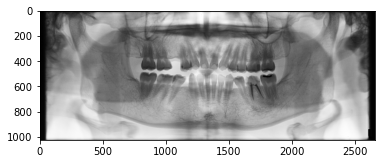

In [33]:
image_names = list(data_dir.glob('*.jpg'))

# image_names = image_names[:10]
image_name = image_names[0]

im = cv2.imread(image_name)
# Only plt imshow need inverse process
plt.imshow(im)
plt.show()


In [34]:
def get_label_by_results(results):
    names = results.names
    target = []
    for result_index in range(len(results)):
        filename = results.files[result_index][:-4]
        filepath_json = data_dir / f'{filename}.json'
        labels = get_labels_by_image(filepath_json)

        temp = []
        for label in labels:
            if label['label'] not in names:
                continue
            points = label['points']
            if len(points) < 2:
                continue
            temp.append([
                names.index(label['label']),
                points[0][0],
                points[0][1],
                points[1][0],
                points[1][1],
            ])

        target.append(torch.tensor(temp).to(device))

    return target



In [35]:
confusion_matrix = ConfusionMatrix(nc=8)

batch_size = 16
names = tooth_detect_model.names
for i in tqdm(range(0, len(image_names), batch_size)):
    tooth_detect_results = tooth_detect_model(image_names[i:i+batch_size])

    target = get_label_by_results(tooth_detect_results)
    for j in range(len(tooth_detect_results)):
        if len(target[j]) == 0:
            continue

        confusion_matrix.process_batch(tooth_detect_results.xyxy[j], target[j])

confusion_matrix.plot(names=names)


100%|██████████| 38/38 [00:47<00:00,  1.25s/it]


In [37]:
confusion_matrix

In [36]:
len(image_names)


600